In [1]:
%load_ext autoreload
%autoreload 2
from mulitmodel import *
from psi4_ import *
from rdkit import Chem
from rdkit.Chem import AllChem

checkpoints/dcm1-10000.0/1-0.053797438740730286-esp_params.pkl
checkpoints/dcm2-10000.0/3-0.025417018681764603-esp_params.pkl
checkpoints/dcm3-10000.0/8-0.016049424186348915-esp_params.pkl
checkpoints/dcm4-10000.0/0-0.015613120049238205-esp_params.pkl


<Figure size 640x480 with 0 Axes>

In [2]:
RANDOM_NUMBER = 0
filename = "test"
data_key, train_key = jax.random.split(jax.random.PRNGKey(RANDOM_NUMBER), 2)

# Create Molecule

In [140]:
smiles = 'c1cc(F)ccc1(O)'
smiles_mol = Chem.MolFromSmiles(smiles)
rdkit_mol = Chem.AddHs(smiles_mol) 
elements = [a.GetSymbol() for a in rdkit_mol.GetAtoms()]
# Generate a conformation
AllChem.EmbedMolecule(rdkit_mol)
coordinates = rdkit_mol.GetConformer(0).GetPositions()
surface = get_grid_points(coordinates)

In [141]:
surface.shape

(2495, 3)

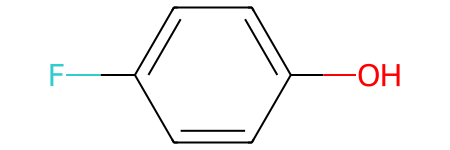

In [142]:
# display molecule
smiles_mol

# Generate ESP from DFT

In [143]:
make_psi4_dir(Path(filename))
surface = get_grid_points(coordinates)
esp_calc(surface, coordinates, elements)

test
Finished ESP


#  Load data

In [144]:
outdata = np.load(Path("/home/boittier/jaxeq/psi4") / "test" / "multipoles.npz")
elements = outdata["elements"]
coordinates = outdata["monomer_coords"] 
monopoles = outdata["monopoles"]
esp = np.fromfile(Path("/home/boittier/jaxeq/psi4") / "test" /  "grid_esp.dat", sep=" ")
grid = outdata["surface_points"] 
vdw_surface = grid 
max_N_atoms = 60
max_grid_points = 3143
max_grid_points - len(vdw_surface)
Z = [np.array([ase.data.atomic_numbers[_.capitalize()] for _ in elements])]
pad_Z = np.array([np.pad(Z[0], ((0,max_N_atoms - len(Z[0]))))])
pad_coords = np.array([np.pad(coordinates, ((0, max_N_atoms - len(coordinates)), (0,0)))])

pad_mono = np.array([np.pad(monopoles,((0,max_N_atoms - len(monopoles)), (0,0)))])
pad_esp =  [np.pad(esp,((0,max_grid_points - len(esp))))]
pad_esp = np.array(pad_esp)
pad_vdw_surface = []
_ = np.pad(vdw_surface, ((0, max_grid_points - len(vdw_surface)), (0,0)), "constant", constant_values=(0, 10000)) 
pad_vdw_surface.append(_)
pad_vdw_surface = np.array(pad_vdw_surface)

data_batch = dict(
    atomic_numbers=jnp.asarray(pad_Z),
    positions=jnp.asarray(pad_coords),
    mono=jnp.asarray(pad_mono),
    ngrid=jnp.array([len(vdw_surface)]),
    esp=jnp.asarray(pad_esp),
    vdw_surface=jnp.asarray(pad_vdw_surface),
)

psi4_test_batches = prepare_batches(data_key, data_batch, batch_size)

batchID = 0
errors_train = []
batch = psi4_test_batches[batchID]

# Generate predictions

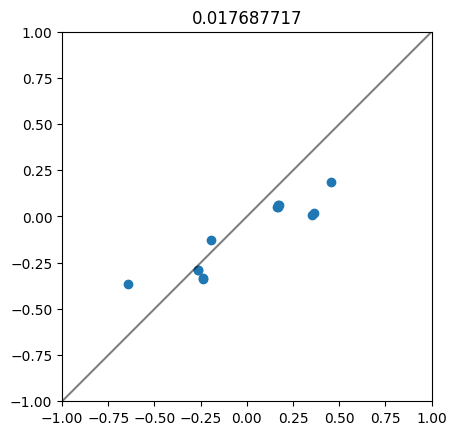

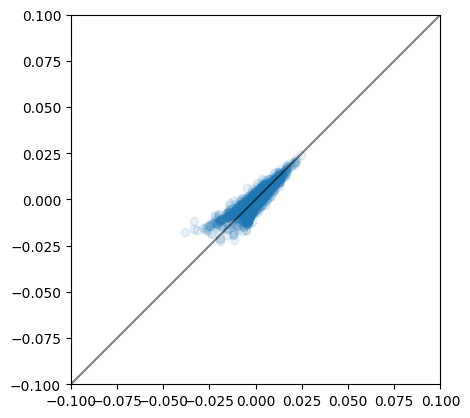

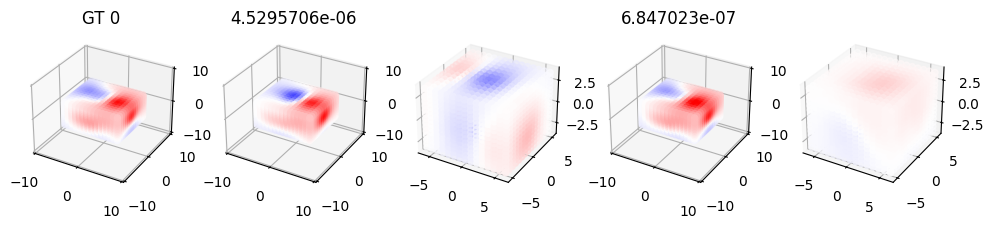

rmse: 1.4158419
[   0    1    2 ... 3140 3141 3142]


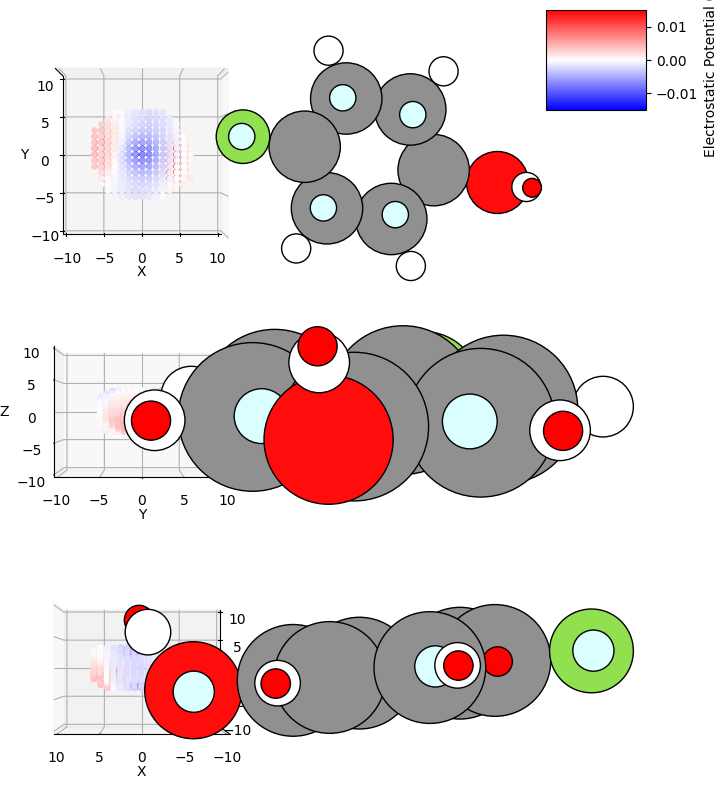

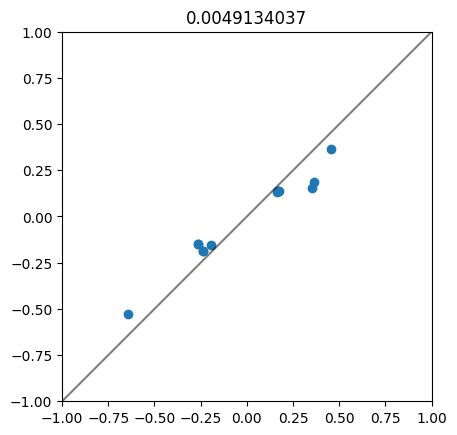

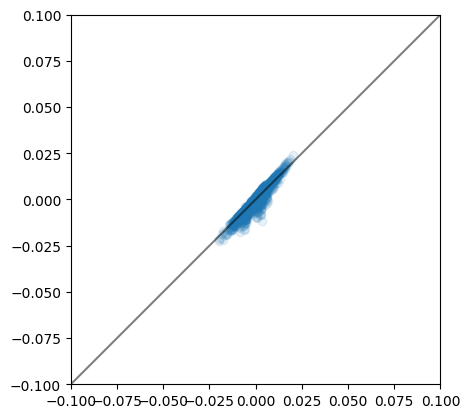

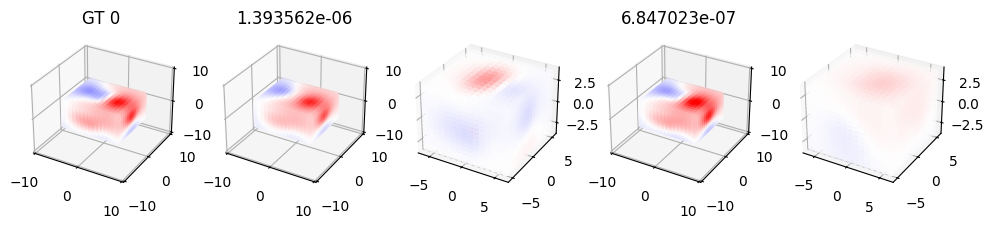

rmse: 0.43559623
[   0    1    2 ... 3140 3141 3142]


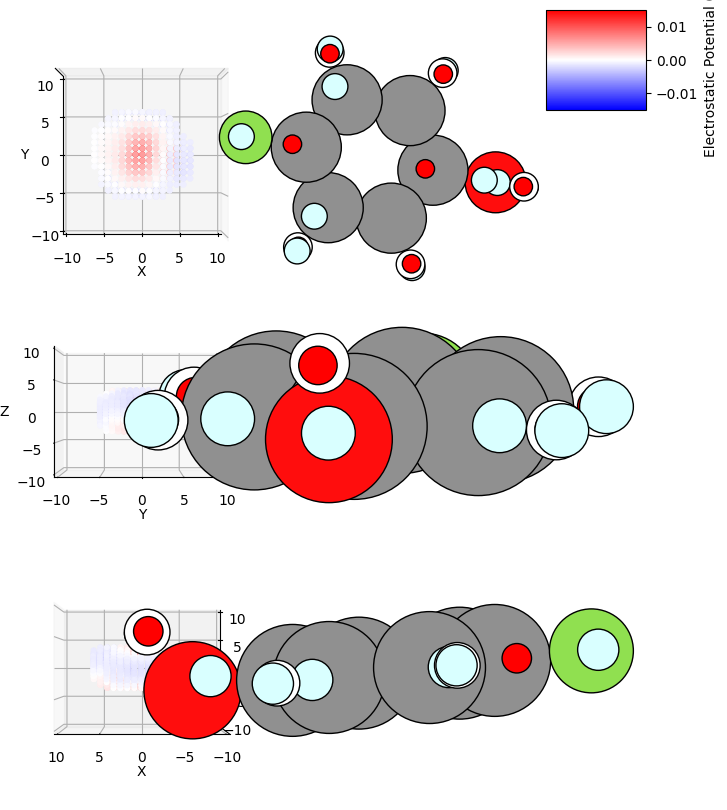

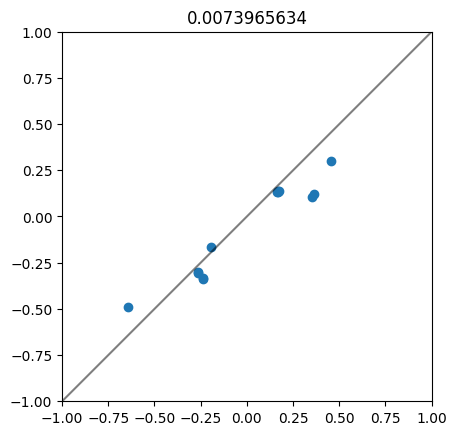

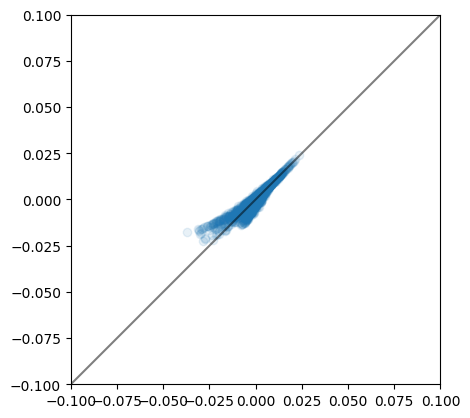

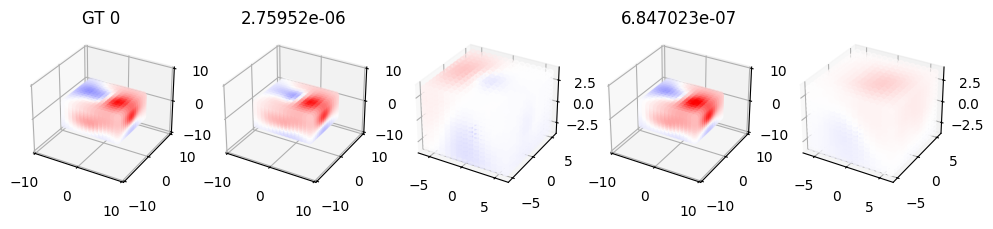

rmse: 0.86256397
[   0    1    2 ... 3140 3141 3142]


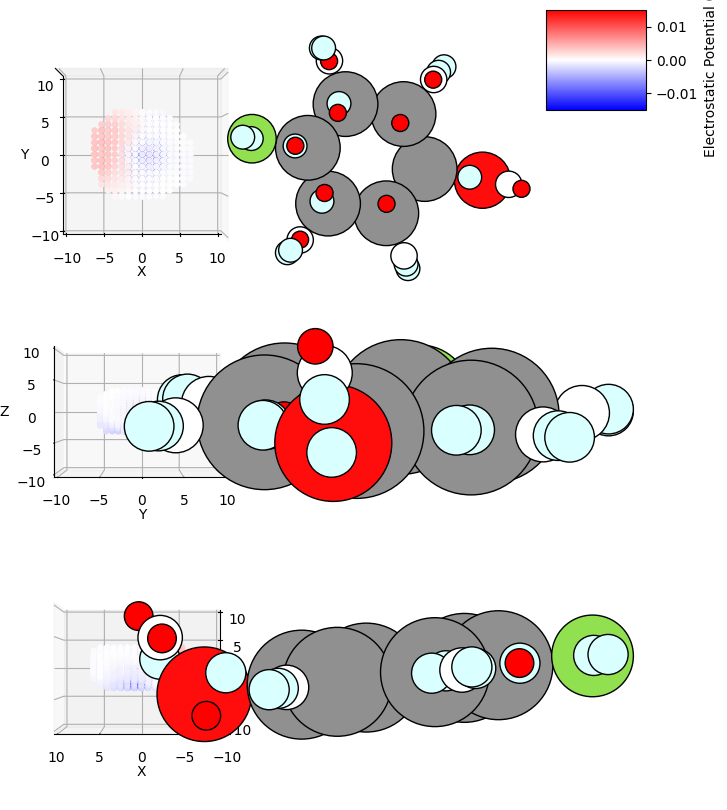

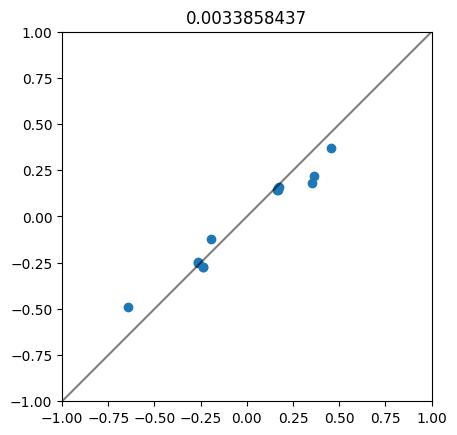

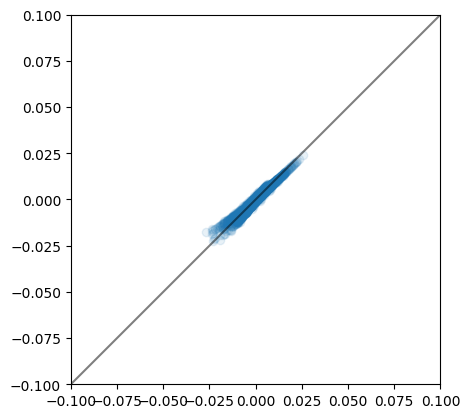

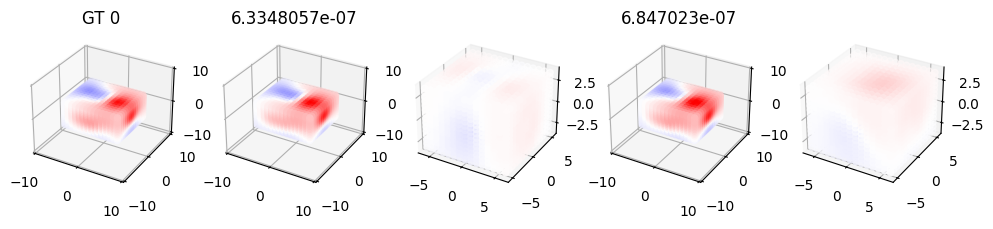

rmse: 0.1980118
[   0    1    2 ... 3140 3141 3142]


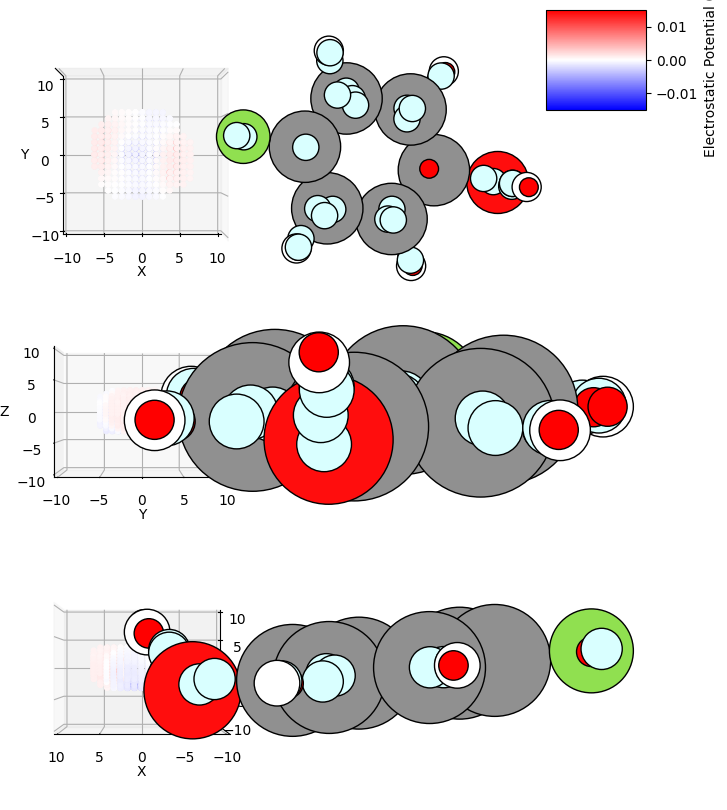

In [145]:
dcm1_results = plot_model(DCM1, dcm1_params, batch, batch_size, 1)
dcm2_results = plot_model(DCM2, dcm2_params, batch, batch_size, 2)
dcm3_results = plot_model(DCM3, dcm3_params, batch, batch_size, 3)
dcm4_results = plot_model(DCM4, dcm4_params, batch, batch_size, 4)

#  View structures

In [146]:
atoms = dcm1_results["atoms"]
dcmol1 = dcm1_results["dcmol"]
dcmol2 = dcm2_results["dcmol"]
dcmol3 = dcm3_results["dcmol"]
dcmol4 = dcm4_results["dcmol"]

# from ase.visualize import view
# view(atoms+dcmol2, viewer="x3d")

In [147]:
dc1, dcq1, atomwise_charge_array1 = make_charge_xyz(
    dcm1_results["mono"], dcm1_results["dipo"], batch, batch_size, 1)
dc2, dcq2, atomwise_charge_array2 = make_charge_xyz(
    dcm2_results["mono"], dcm2_results["dipo"], batch, batch_size, 2)
dc3, dcq3, atomwise_charge_array3 = make_charge_xyz(
    dcm3_results["mono"], dcm3_results["dipo"], batch, batch_size, 3)
dc4, dcq4, atomwise_charge_array4 = make_charge_xyz(
    dcm4_results["mono"], dcm4_results["dipo"], batch, batch_size, 4)

# Combine and Optimize

In [148]:
combined = combine_chg_arrays(batch,
                              atomwise_charge_array1, #Hs
                              atomwise_charge_array1
                              )
get_esp_rmse_from_combined(combined, batch) * 627.59**2

(13, 4)


Array(1.7840585, dtype=float32)

In [149]:
opt_job = OptimizeCombined(combined, batch)
res, combined_pred_esp, new_combined = opt_job.optimize()

(13,)


/home/boittier/psi4conda/envs/jaxe3xcuda11py39/lib/python3.9/site-packages/scipy/optimize/_minimize.py:719: OptimizeWarning: Unknown solver options: xatol, adaptive, ftol, eps, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Optimization terminated successfully.
   Normal return from subroutine COBYLA


   NFVALS = 3998   F = 1.613441E-07    MAXCV =-0.000000E+00
   X = 1.000000E-01   1.000000E-01   1.000000E-01  -8.385585E-02   8.491788E-02
       1.000000E-01   1.000000E-01  -1.000000E-01   2.153758E-02   9.676941E-03
       1.579496E-02   1.922238E-02   5.205227E-02


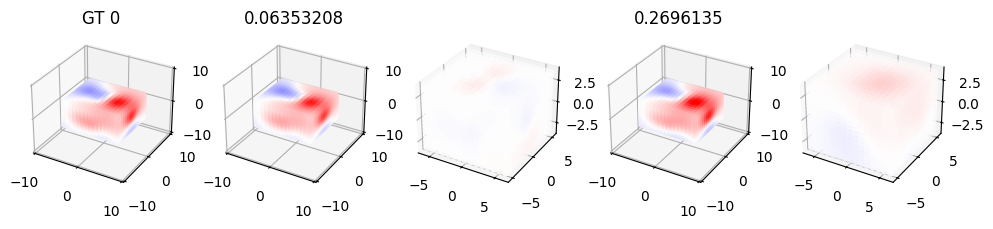

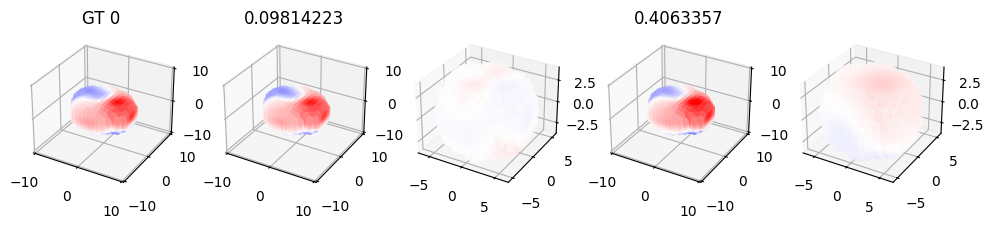

In [150]:
plot_esp(combined_pred_esp, batch, rcut=100.0)
plot_esp(combined_pred_esp, batch, rcut=4.0)

In [151]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3

In [152]:
combined = combine_chg_arrays(batch,
                              atomwise_charge_array1,
                              atomwise_charge_array2
                              )
get_esp_rmse_from_combined(combined, batch)

(21, 4)


Array(2.2095295e-05, dtype=float32)

In [153]:
opt_job = OptimizeCombined(combined, batch)
res, combined_pred_esp, new_combined = opt_job.optimize()

(21,)


/home/boittier/psi4conda/envs/jaxe3xcuda11py39/lib/python3.9/site-packages/scipy/optimize/_minimize.py:719: OptimizeWarning: Unknown solver options: xatol, adaptive, ftol, eps, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Maximum number of function evaluations has been exceeded.
   Return from subroutine COBYLA because the MAXFUN limit has been reached.


   NFVALS = 4000   F = 1.323343E-07    MAXCV = 0.000000E+00
   X =-7.483932E-02  -8.700526E-03  -6.691572E-02  -1.000000E-01  -9.151477E-02
       1.279899E-02  -2.677838E-03  -5.191689E-02  -5.209079E-02  -9.999924E-02
      -1.935622E-02  -1.000000E-01  -6.422816E-02  -7.424168E-02   5.679094E-03
      -2.248880E-02   8.922967E-02   7.800032E-02   7.285212E-02   8.325389E-02
       9.911189E-02


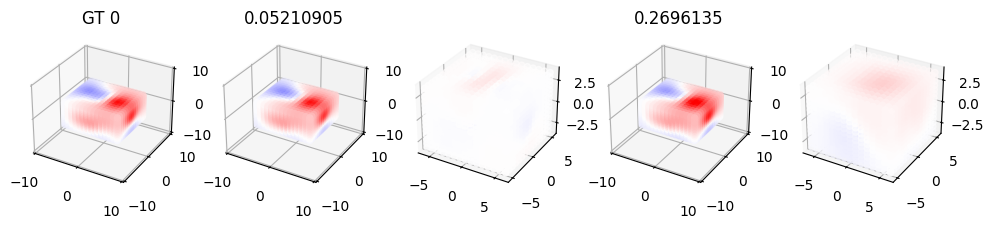

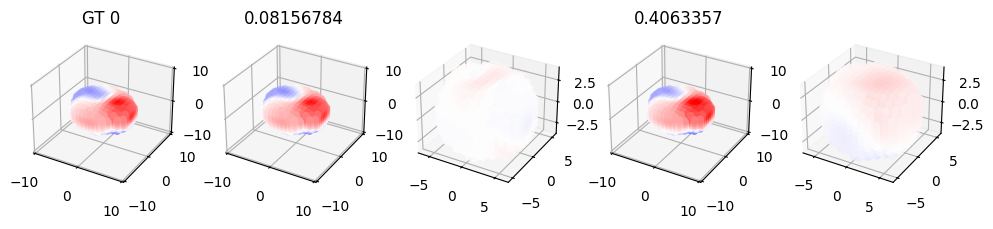

In [154]:
plot_esp(combined_pred_esp, batch, rcut=100.0)
plot_esp(combined_pred_esp, batch, rcut=4.0)

In [155]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3

In [156]:
combined = combine_chg_arrays(batch,
                              atomwise_charge_array1,
                              atomwise_charge_array3
                              )
get_esp_rmse_from_combined(combined, batch)

(29, 4)


Array(2.1116166e-05, dtype=float32)

In [157]:
opt_job = OptimizeCombined(combined, batch)
res, combined_pred_esp, new_combined = opt_job.optimize()

(29,)
Maximum number of function evaluations has been exceeded.

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 4000   F = 2.505370E-07    MAXCV = 5.551115E-17
   X =-6.032233E-02  -7.200162E-02  -4.668068E-02   5.400416E-02  -3.633454E-02
      -9.407085E-02  -9.375495E-02  -7.410585E-02  -9.491658E-02  -6.643887E-02
      -9.857889E-02  -7.539212E-02  -1.000000E-01  -7.407327E-02   9.035269E-02
      -1.000000E-01   2.498591E-03  -8.073175E-02  -4.496561E-02   3.226720E-02
      -8.973409E-02  -1.000000E-01  -6.775220E-02   4.468206E-03   3.467561E-02
       1.696991E-02   4.174308E-03   3.807412E-02   1.901568E-02


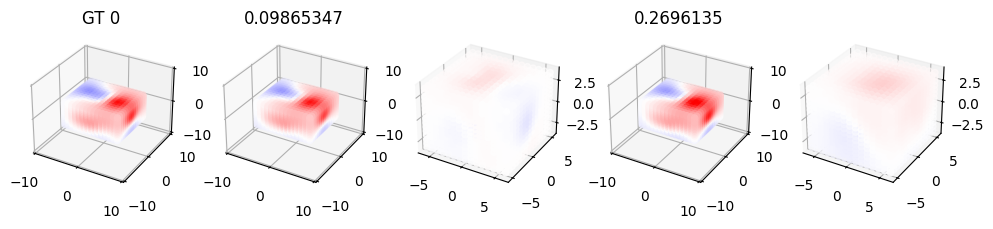

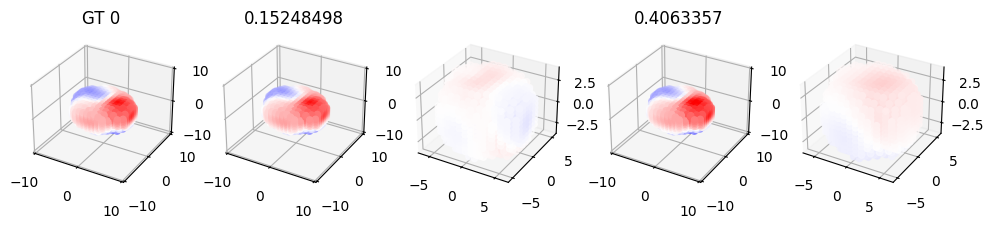

In [158]:
plot_esp(combined_pred_esp, batch, rcut=100.0)
plot_esp(combined_pred_esp, batch, rcut=4.0)

In [159]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3

In [160]:
combined = combine_chg_arrays(batch,
                              atomwise_charge_array1,
                              atomwise_charge_array4
                              )
get_esp_rmse_from_combined(combined, batch)

(37, 4)


Array(2.496118e-05, dtype=float32)

In [161]:
opt_job = OptimizeCombined(combined, batch)
res, combined_pred_esp, new_combined = opt_job.optimize()

(37,)
Maximum number of function evaluations has been exceeded.
   Return from subroutine COBYLA because the MAXFUN limit has been reached.


   NFVALS = 4000   F = 9.177469E-08    MAXCV = 5.584534E-07
   X =-4.754363E-02  -9.194026E-02  -9.874305E-02   2.894930E-03  -4.797961E-02
      -8.691315E-02  -5.736213E-02   9.903717E-02  -8.793956E-02   1.690274E-02
      -9.704856E-02  -9.799688E-02  -7.795748E-02  -7.106532E-02  -3.188095E-02
      -3.300503E-02  -7.994585E-02   8.150053E-02  -1.000006E-01  -2.382196E-03
       6.974979E-02  -6.655444E-02  -9.996888E-02  -9.734822E-02   3.929810E-02
      -8.258339E-02  -9.496478E-02   3.041748E-02   9.060370E-02  -9.996522E-02
      -7.739145E-02  -8.136839E-02   6.863059E-02   2.771163E-02   3.728102E-02
       3.816862E-02   6.818021E-02


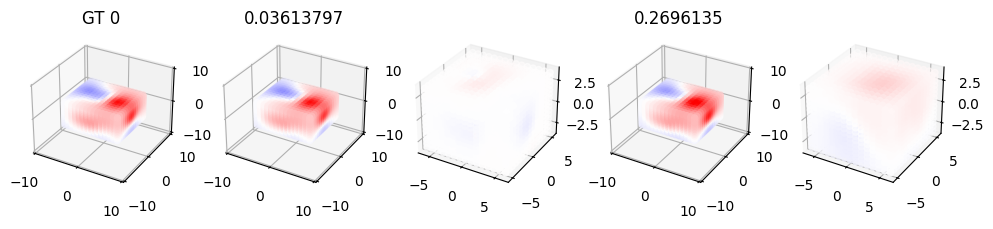

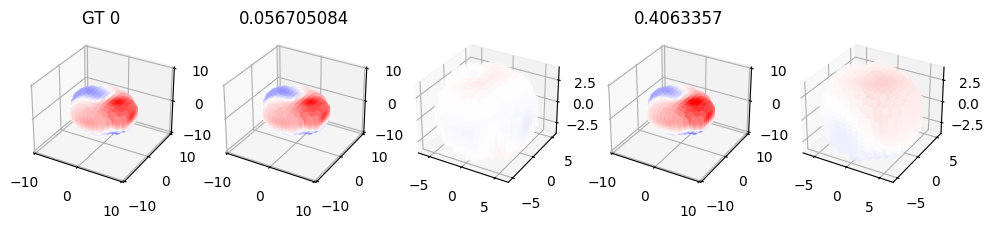

In [162]:
plot_esp(combined_pred_esp, batch, rcut=100.0)
plot_esp(combined_pred_esp, batch, rcut=4.0)

In [163]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3